# Решение задачи классификации для рекомендации тарифов

В нашем распоряжении данные о поведении клиентов телекоммуникационной компании, перешедших на один из двух тарифов. Для решения задачи выбора тарифов, подходящих клиентам на основе их потребительского поведения, построим и пронализируем модели для задачи классификации.

## Содержание
- [Описание данных](#0)
1. [Импорт библиотек. Загрузка и изучение данных](#1)    
2. [Формирование выборок](#2)    
3. [Исследование качества моделей](#3)
    - [Решающие деревья](#3_1)
    - [Случайный лес](#3_2)
    - [Логистическая регрессия](#3_3) 
    - [Градиентный бустинг](#3_4) 
4. [Проверка качества моделей на тестовой выборке](#4)
5. [Проверка моделей на вменяемость](#5)
- [Выводы](#6)

<a id="0"></a> 
## Описание данных
Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
- сalls — количество звонков,
- minutes — суммарная длительность звонков в минутах,
- messages — количество sms-сообщений,
- mb_used — израсходованный интернет-трафик в Мб,
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

<a id="1"></a> 
## Импорт библиотек. Загрузка и изучение данных

In [ ]:
# импорт библиотек
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, \
                            classification_report, matthews_corrcoef

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV, cross_val_score

from catboost import CatBoostClassifier

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

In [ ]:
# загрузка данных
df = pd.read_csv('/content/drive/My Drive/Datasets/users_behavior.csv')

Посмотрим на данные

In [ ]:
display(df.info(), df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


None

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


Данные в порядке и готовы к анализу.  
В качестве целевой переменной принимаем значения `is_ultra`.
________________

Визуализируем данные. Для начала построим матрицу рассеяния.

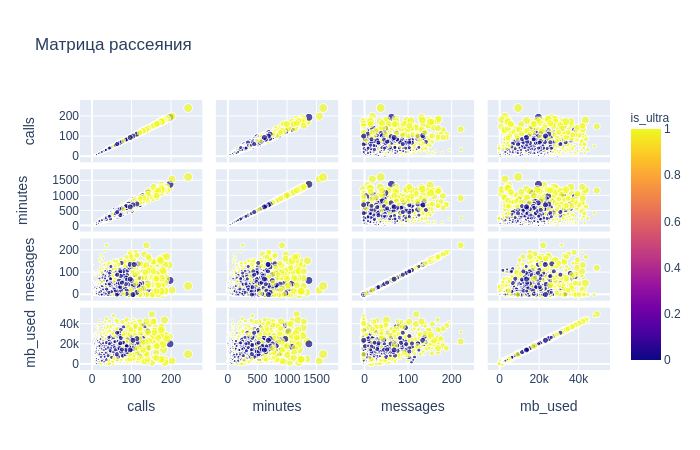

In [ ]:
fig = px.scatter_matrix(df, 
                        dimensions=['calls', 'minutes', 'messages', 'mb_used'],
                        size='calls', 
                        size_max=5,
                        color='is_ultra',
                        labels=[col for col in df.columns],
                        title='Матрица рассеяния'
                       )
fig.show('png')

Как можно было предполагать, имеется выраженная прямая зависимость между количеством звонков и их продолжительностью.  
Проверим значение корреляции.

In [ ]:
df.calls.corr(df.minutes)

0.9820832355742293

Очевидно наличие мультиколлинеарности. Это может негативно сказаться на качестве линейной модели, учтем данный факт в дальнейшей работе.

Попробуем посмотреть на данные во всех измерениях.  
Сделаем 3D-визуализацию, пожертвовав признаком `calls`.  
Далее воспользуемся алгоритмом стохастического вложения соседей с t-распределением для визуализации данных нашей размерности в двухмерном пространстве.  
Раскрасим данные по значению тарифа ("Ультра" будет желтым).

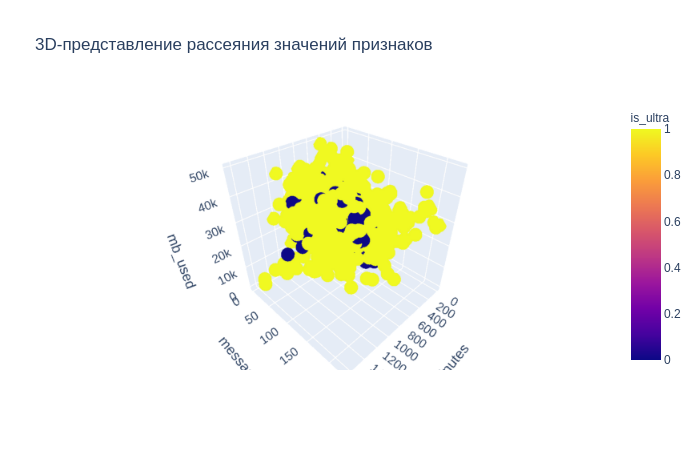

In [ ]:
fig = px.scatter_3d(df, x='minutes', y='messages', 
                    z='mb_used', color='is_ultra',
                    title='3D-представление рассеяния значений признаков')
fig.show('png')

In [ ]:
X = df.iloc[:, :-1]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

tsne = TSNE(random_state=123)
tsne_representation = tsne.fit_transform(X_scaled)

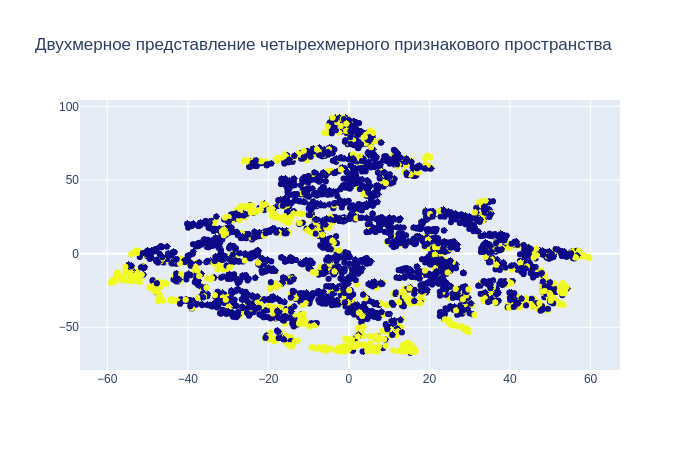

In [ ]:
fig = go.Figure(data=go.Scatter(x=tsne_representation[:, 0], 
                                y=tsne_representation[:, 1], 
                                mode='markers', 
                                marker=dict(color=df.is_ultra),                               
                                )
               )    
fig.update_layout(title='Двухмерное представление четырехмерного признакового пространства')
fig.show('png')

На всех графиках видно, что синие маркеры собраны более плотно, в то время как желтые как бы "обволакивают" их.  

Очевидно, что поведение пользователей тарифа "Ультра" является более разнообразным, а пользователи тарифа "Смарт" тяготеют к ограниченному использованию своего пакета услуг, что означает в целом более низкие значения независимых переменных по нулевому классу.  

<a id="2"></a> 
## 2. Формирование выборок

Разобъем данные на обучающую, валидационную и тестовую выборки в соотношении 3:1:1.  
С учетом выявленной мультиколлинеарности, значения признака `calls` использовать не будем.

In [ ]:
# для начала разобъем данные в соотношении 80/20 для выделения тестовой выборки
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 1:-1], 
                                                    df.iloc[:, -1], 
                                                    test_size=0.2, 
                                                    random_state=123
                                                   )

# разобъем 80% в соотношении 3:1 и получим обучающую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train, 
                                                  test_size=0.25, # 0.25 x 0.8 = 0.2
                                                  random_state=123
                                                 ) 

# проверим соотношение и количество элементов в выборках
for y in y_train, y_val, y_test:
    print('{:.0%}'.format(len(y) / len(df)), end=' ')
    print(len(y))

60% 1928
20% 643
20% 643


<a id="3"></a> 
## 3. Исследование качества моделей

Напишем функцию, возвращающую значения `accuracy` для обучающей и валидационной выборок в зависимости от выбранного алгоритма и гиперпараметров.

In [ ]:
def model_eval(classifier, **params):
    model = classifier(random_state=123, **params)
    model.fit(X_train, y_train)
    train_accuracy = accuracy_score(y_train, model.predict(X_train))
    val_accuracy = accuracy_score(y_val, model.predict(X_val))
    return [train_accuracy, val_accuracy]

<a id="3_1"></a> 
### Решающие деревья

Проанализируем работу `DecisionTreeClassifier` в зависимости от выбранных критериев останова (глубина и количество объектов в вершине) при заданном критерии информативности.  
Построим графики зависимости значения `Accuracy` от значений вышеуказанных гиперпараметров.

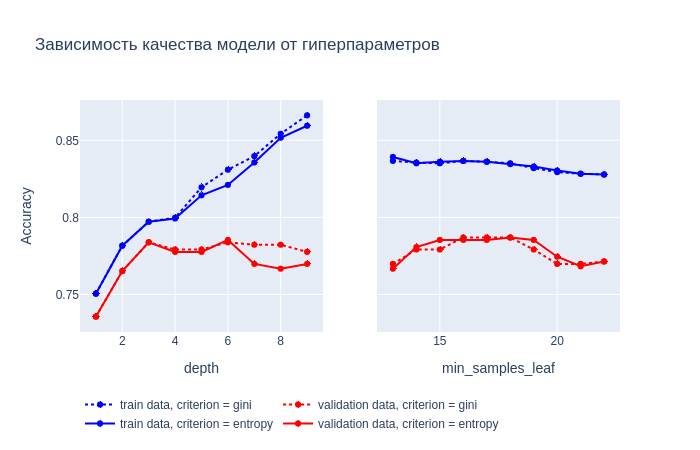

In [ ]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, shared_yaxes=True)
for criterion in 'gini', 'entropy':
    
    matrix = []
    for depth in range(1, 10):
        scores = model_eval(DecisionTreeClassifier,
                            criterion=criterion, 
                            max_depth=depth
                           )
        scores.append(depth)
        matrix.append(scores)
        
    matrix = np.array(matrix)
    
    fig.add_trace(go.Scatter(
        x=matrix[:,2], # depth
        y=matrix[:,0], # train score
        legendgroup='1',
        showlegend=False,
        name='train data, criterion = ' + criterion,
        line=dict(color='blue', 
                  dash='dot' if criterion == 'gini' else None)),
                  1, 1
                 )
    fig.add_trace(go.Scatter(
        x=matrix[:,2], # depth
        y=matrix[:,1], # val score
        legendgroup='2',
        showlegend=False,
        name='validation data, criterion = ' + criterion,
        line=dict(color='red', 
                  dash='dot' if criterion == 'gini' else None)), 
                  1, 1
                 )                     
      
    matrix = []
    for n_samples in range(13, 23):
        scores = model_eval(DecisionTreeClassifier, 
                            criterion=criterion, 
                            min_samples_leaf=n_samples
                           )
        scores.append(n_samples)
        matrix.append(scores)
    matrix = np.array(matrix)
    
    fig.add_trace(go.Scatter(
        x=matrix[:,2], 
        y=matrix[:,0], 
        legendgroup='1',
        name='train data, criterion = ' + criterion,
        line=dict(color='blue', 
                  dash='dot' if criterion == 'gini' else None)), 
                  1, 2
                 )
    fig.add_trace(go.Scatter(
        x=matrix[:,2], 
        y=matrix[:,1],
        legendgroup='2',
        name='validation data, criterion = ' + criterion,
        line=dict(color='red', 
                  dash='dot' if criterion == 'gini' else None)), 
                  1, 2
                 )
    
fig.update_yaxes(title_text='Accuracy', row=1, col=1)
fig.update_xaxes(title_text='depth', row=1, col=1)
fig.update_xaxes(title_text='min_samples_leaf', row=1, col=2)

fig.update_layout(title='Зависимость качества модели от гиперпараметров',
                   legend=dict(orientation="h", 
                               y=-0.25
                              )
                 )

fig.show('png')

Мы видим, что оба критерия информативности показывают близкие результаты. Заметим, что и в общем случае можно показать, что при удвоении значений неопределенности Джини они будут близки к значениям энтропии в функции от вероятности появления одного из классов.  

Что касается ограничения максимальной глубины и минимального количества объектов в вершинах, то можно также говорить о сопоставимости достижимых результатов при работе с этими критериями.  

Будем ориентироваться на такие значения гиперпараметров, которые позволят максимизировать `accuracy` на обучающей и тестовой выборках одновременно.

Обучим дерево решений исходя из сделанных наблюдений.

In [ ]:
dtc = (DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=123)
       .fit(X_train, y_train)      
      )

Посмотрим на значения метрик точности, полноты и F-меры, а также рассчитаем коэффициент корреляции Мэтьюса.

In [ ]:
def clf_report(X, y, model):
    prediction = model.predict(X)
    print(classification_report(y, prediction))
    print('MCC:', matthews_corrcoef(y, prediction))
    print('Accuracy (full):', accuracy_score(y, prediction))
    
clf_report(X_val, y_val, dtc)

              precision    recall  f1-score   support

           0       0.79      0.92      0.85       440
           1       0.74      0.48      0.59       203

    accuracy                           0.78       643
   macro avg       0.77      0.70      0.72       643
weighted avg       0.78      0.78      0.77       643

MCC: 0.4666085490414001
Accuracy (full): 0.7838258164852255


Мы получили в определенной мере неплохие значения, однако обратим внимание на относительно слабую полноту по классу `1`, что означает срабатывание нашего алгоритма лишь на 48% истинных объектах данного класса (тариф "Ультра").

Теперь проведем настройку тех же гиперпараметров на кросс-валидации. На этот раз попробуем совместную настройку всех трех параметров.

In [ ]:
dtc_params = {'min_samples_leaf': range(13, 23), 
              'max_depth': range(1, 10), 
              'criterion': ['entropy', 'gini']
             }
dtc_cv = GridSearchCV(dtc, dtc_params)
dtc_cv.fit(X_train, y_train)
dtc_cv.best_params_

{'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 14}

In [ ]:
clf_report(X_val, y_val, dtc_cv)

              precision    recall  f1-score   support

           0       0.80      0.92      0.86       440
           1       0.74      0.51      0.60       203

    accuracy                           0.79       643
   macro avg       0.77      0.71      0.73       643
weighted avg       0.78      0.79      0.78       643

MCC: 0.4810434583826017
Accuracy (full): 0.7884914463452566


Как видим, мы получили некоторое улучшение результата. При этом отметим, что подбор параметров в более широком диапазоне значений `max_depth` и `min_samples_leaf` дает несколько худшие результаты, так же как и рассмотрение сочетаний лишь двух параметров из трех рассматриваемых (`criterion` и `max_depth` или `criterion` и `min_samples_leaf`). В этом легко убедиться, меняя значения в словаре `dtc_params`.

Рассмотрим другие алгоритмы более кратко. 

<a id="3_2"></a> 
### Случайный лес

Выберем гиперпараметры для случайного леса на кросс-валидации.

In [ ]:
rfc = RandomForestClassifier(random_state=123)

rfc_params = {'n_estimators': range(10, 120, 20), 
              'max_depth': [10, 50, None], 
             }

rfc_cv = GridSearchCV(rfc, rfc_params)
rfc_cv.fit(X_train, y_train)
rfc_cv.best_params_

{'max_depth': 10, 'n_estimators': 90}

Проверим качество на валидационной выборке.

In [ ]:
clf_report(X_val, y_val, rfc_cv)

              precision    recall  f1-score   support

           0       0.80      0.94      0.87       440
           1       0.80      0.50      0.61       203

    accuracy                           0.80       643
   macro avg       0.80      0.72      0.74       643
weighted avg       0.80      0.80      0.79       643

MCC: 0.5160661272695275
Accuracy (full): 0.80248833592535


Как можно было ожидать, качество оказалось несколько выше, но ощутимого улучшения получить не удалось.

<a id="3_3"></a> 
### Логистическая регрессия

Проделаем такие же шаги для логистической регрессии.

In [ ]:
lrc = LogisticRegression()

lrc_params = {'penalty': ['l1', 'l2'], 
              'C': np.logspace(0, 4, 10), 
             }

lrc_cv = GridSearchCV(lrc, lrc_params)
lrc_cv.fit(X_train, y_train)
lrc_cv.best_params_

{'C': 1.0, 'penalty': 'l2'}

Проверим качество на валидационной выборке.

In [ ]:
clf_report(X_val, y_val, lrc_cv)

              precision    recall  f1-score   support

           0       0.71      0.97      0.82       440
           1       0.68      0.13      0.22       203

    accuracy                           0.71       643
   macro avg       0.70      0.55      0.52       643
weighted avg       0.70      0.71      0.63       643

MCC: 0.19869715256899415
Accuracy (full): 0.7060653188180405


Очевидно, что логистическая регрессия для данного случая работает хуже других алгоритмов, что обусловлено сепцифичностью наших данных, которую хорошо отражают графики, построенные нами в первой части исследования.

<a id="3_4"></a> 
### Градиентный бустинг

Проверим, улучшит ли результаты градиентный бустинг.

In [ ]:
cbc = CatBoostClassifier(random_state=123, verbose=0)
cbc.fit(X_train, y_train, eval_set=(X_val, y_val))
clf_report(X_val, y_val, cbc)

              precision    recall  f1-score   support

           0       0.80      0.94      0.87       440
           1       0.80      0.50      0.62       203

    accuracy                           0.80       643
   macro avg       0.80      0.72      0.74       643
weighted avg       0.80      0.80      0.79       643

MCC: 0.5161003610515433
Accuracy (full): 0.80248833592535


Результаты сопоставимы с полученными на Random Forest. Посмотрим, что нам покажет тестовая выборка.

<a id="4"></a> 
## 4. Проверка качества моделей на тестовой выборке

Напишем функцию для создания словаря из интересующих нас метрик. 

In [ ]:
def metrics(model):
    prediction = model.predict(X_test)
    prfs = precision_recall_fscore_support(y_test, prediction)
    result = {'Precision': prfs[0], 
              'Recall': prfs[1], 
              'F-Score': prfs[2], 
              'Accuracy': accuracy_score(y_test, prediction),
              'MCC': matthews_corrcoef(y_test, prediction) 
             }
    return result

Сведем все метрики в одну таблицу.

In [ ]:
clf_dict = {'Tree (manual)': dtc, 
            'Tree (CV)': dtc_cv, 
            'RF (CV)': rfc_cv, 
            'LogReg (CV)': lrc_cv,
            'G-Boosting': cbc
           }

_ = []
for key, clf in clf_dict.items():  
    _.append(pd.DataFrame(metrics(clf), 
                          index=[key+', class 0', key+', class 1']
                         )
            )
    
display(pd.concat(_).sort_values(by='MCC', ascending=False))

,Precision,Recall,F-Score,Accuracy,MCC
"G-Boosting, class 0",0.830040,0.933333,0.878661,0.819596,0.545928
"G-Boosting, class 1",0.781022,0.554404,0.648485,0.819596,0.545928
"RF (CV), class 0",0.822134,0.924444,0.870293,0.807154,0.512781
"RF (CV), class 1",0.751825,0.533679,0.624242,0.807154,0.512781
"Tree (manual), class 0",0.810707,0.942222,0.871531,0.805599,0.504978
"Tree (manual), class 1",0.783333,0.487047,0.600639,0.805599,0.504978
"Tree (CV), class 0",0.811765,0.920000,0.862500,0.794712,0.478183
"Tree (CV), class 1",0.729323,0.502591,0.595092,0.794712,0.478183
"LogReg (CV), class 0",0.712219,0.984444,0.826493,0.710731,0.146936
"LogReg (CV), class 1",0.666667,0.072539,0.130841,0.710731,0.146936


Как мы видим, композиционные алгоритмы ожидаемо лидируют, а линейная модель в данном случае имеет наихудшее качество. 
При этом на всех моделях нам удалось получить значение `Accuracy` более 0.75.  

<a id="5"></a> 
## 5. Проверка моделей на вменяемость

Сравним нашу модель с константной. Возьмем метку наибольшего класса и вычислим `accuracy` как долю объектов этого класса в выборке. Сделаем это для всей совокупности и имеющихся выборок из нее.

In [ ]:
for y in df.iloc[:, -1], y_train, y_val, y_test:
    print(np.bincount(y).max() / len(y))

0.693528313627878
0.6945020746887967
0.6842923794712286
0.6998444790046656


Если $q_0$ - доля объектов самого крупного класса, тогда для того, чтобы мы могли говорить о вменяемости модели, должно выполняться условие $accuracy \in [q_0, 1]$.  
В данном случае условие выполнено.


<a id="6"></a> 
## Выводы

В рамках настоящей работы мы рассмотрели данные о поведении клиентов, перешедших на один из двух тарифов сотовой связи.

Мы построили и пронализировали модели для классификации тарифов, используя алгоритмы деревьев решений, случайного леса, линейной регрессии и градиентного бустинга. Для моделей рассматривались и подбирались оптимальные значения основных гиперпараметров.  Для оценки качества мы использовали ряд метрик, таких как точность, полноста, f-мера, доля правильных ответов (accuracy) и коэффициент корреляции Мэтьюса, на две последние из которых мы главным образом опирались.

Мы показали, что композиционные алгоритмы позволяют добиться более выского уровня качетсва, а линейная модель в данном случае имеет наихудшее качество.  

На всех моделях нам удалось получить долю правильных ответов более 0.75 (до 0.81), что, как мы убедились, выше аналогичного показателя для константной модели. А это означает адекватность и потенциальную применимость построенных моделей, хотя и стоит отметить, что мы не можем говорить о выдающихся результатах.